In [1]:
%load_ext autoreload
%autoreload 2
from paths import *

from matplotlib import pyplot as plt
import torch
from src.SERS_dataset import IterDataset
from src.generate_data2 import pseudoVoigtSimulatorTorch
from src.plotting.save_plot import save_plot
from src.plotting.VAE_plotting import plot_losses_3_2, plt_recons_with_dist, plt_sigma_as_func_of_alpha_and_c
# import make_axes_locatable
import numpy as np
import dill
import io
import time

# matplotlib style seaborn-whitegrid
plt.style.use('seaborn-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

c:\Users\andre\OneDrive - Danmarks Tekniske Universitet\Bachelorprojekt\Code\bachelor-project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\andre\AppData\Local\Temp\ipykernel_29476\546355633.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
# load model that has been trained on GPU on CPU. Source https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(dill.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

def load_dill(file_name, experiment):
    file_name = os.path.join(results_dir, experiment, file_name)
    with open(file_name, 'rb') as f:
        contents = CPU_Unpickler(f).load()
    autoencoder = contents["model"]
    train_loss = contents["train_loss"]
    generator_num = contents["generator"]

    return autoencoder, train_loss, generator_num

In [12]:
models = ["golden-breeze-579", "breezy-darkness-583", "grievous-parsec-355"]
labels_dict = {1: "alpha", 2: "c", 3: ["c", "alpha"]}

In [8]:
for model_name in models:
    autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "3_VAE_voigt_decoder")

    generator_num = 3
    ps = pseudoVoigtSimulatorTorch(500)
    generator = ps.predefined_generator(generator_num)
    dset_train = IterDataset(generator)
    train_loader = torch.utils.data.DataLoader(dset_train, batch_size=100, pin_memory=cuda)

    times = []
    good_estimate = []

    for i in range(100):
        
        x, y = next(iter(train_loader))
        x = x.to(device)
        y = y.to(device)

        time_start = time.time()
        autoencoder.encode(x)
        time_end = time.time()

        z, mu, logvar = autoencoder.encode(x)


        times.append(time_end - time_start)
        mu_true = torch.stack((y[:,0]/500, y[:,3]), dim=1)[:,:,0]
        mu_true = mu_true.cpu().detach().numpy()
        ge = abs(mu.cpu().detach().numpy() - mu_true) < [0.01, 0.1]
        ge_perc = np.sum(np.sum(ge, axis=1) == 2)/100
        good_estimate.append(ge_perc)

    print("Generator number:", generator_num, "(" + model_name + ")")
    print("   Mean inference time for a batch: ", np.mean(times))
    print("   Good estimates: ", np.mean(good_estimate))

Generator number: 3 (golden-breeze-579)
   Mean inference time for a batch:  0.013917100429534913
   Good estimates:  0.0
Generator number: 3 (breezy-darkness-583)
   Mean inference time for a batch:  0.027944765090942382
   Good estimates:  0.0002


Generator 1 (golden-breeze-579)
   loss 381.87449784712356
   kl 19.07691140608354
   elbo -381.87449784712356
   logpx -362.797588001598
   MSE 0.2499019286849282
   MSE (mu) 0.25210633873939514 (validation batch)
   MSE (z) 0.25253036618232727 (validation batch)



IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 800x550 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

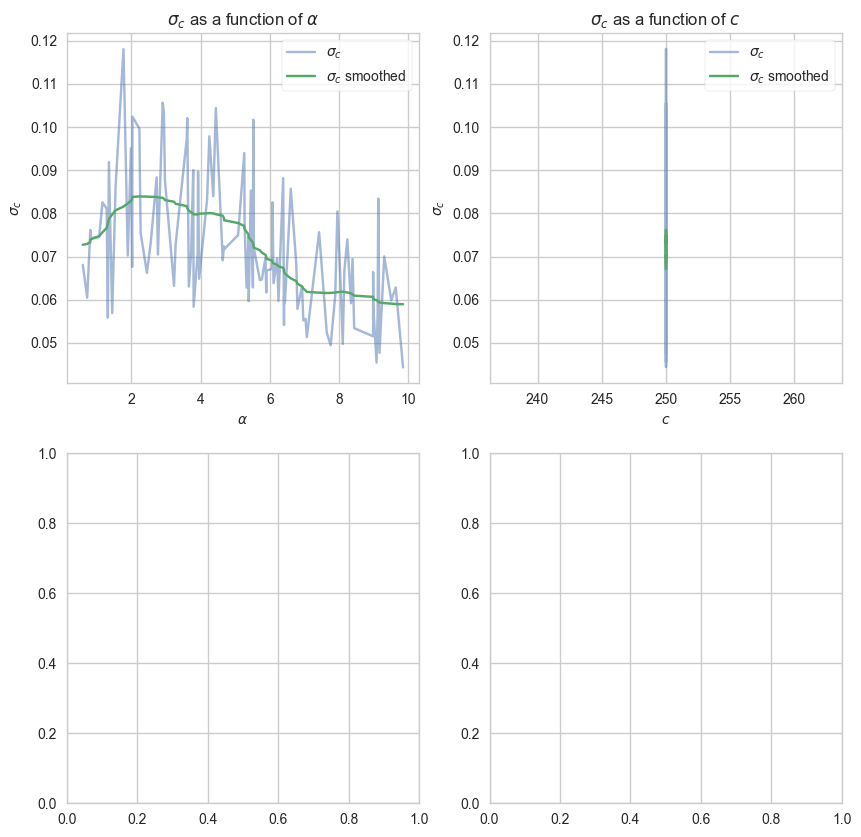

In [18]:
ps = pseudoVoigtSimulatorTorch(500)

for model_name in models:
    autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "3_VAE_voigt_decoder")
    generator = ps.predefined_generator(generator_num)
    dset_train = IterDataset(generator)
    train_loader = torch.utils.data.DataLoader(dset_train, batch_size=100, pin_memory=cuda)

    print("Generator", generator_num, "(" + model_name + ")")
    for key, value in train_loss.items():
        print("  ", key, value[-1])

    x, y = next(iter(train_loader))
    x = x.to(device)
    y = y.to(device)
    z, mu, logvar = autoencoder.encode(x)
    sigma = torch.exp(0.5 * logvar)
    x_hat = autoencoder.decode(z)
    x_hat_mu = autoencoder.decode(mu)

    MSE = torch.nn.MSELoss()
    loss = MSE(x_hat_mu, x)
    print("   MSE (mu)", loss.item(), "(validation batch)")
    loss = MSE(x_hat, x)
    print("   MSE (z)", loss.item(), "(validation batch)")
    print()

    x = x.cpu().detach().numpy()
    x_hat = x_hat.cpu().detach().numpy()
    x_hat_mu = x_hat_mu.cpu().detach().numpy()
    sigma = sigma.cpu().detach().numpy()
    mu = mu.cpu().detach().numpy()
    z = z.cpu().detach().numpy()

    

    # recons = autoencoder.decode(z)
    label = labels_dict[generator_num]

    ll = {"c": 0, "gamma": 1, "eta": 2, "alpha": 3}
    labels = []
    if isinstance(label, list):
        for l in label:
            labels.append(y[:,ll[l]])
    else:
        labels.append(y[:,ll[label]])
        label = [label]

    plot =  plot_losses_3_2(train_loss, 3)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt", "vae_voigt_losses_" + "_".join(label)), ["pdf", "png"])
    plot = plt_recons_with_dist(x, x_hat_mu, mu, sigma, y, generator_num, 3, 2)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt", "vae_voigt_reconstructions_" + "_".join(label)), ["pdf", "png"])
    if generator_num == 3:
        plot = plt_sigma_as_func_of_alpha_and_c(mu, sigma, y)
        save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt", "vae_voigt_sigmas_" + "_".join(label)), ["pdf", "png"])

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 800x550 with 0 Axes>

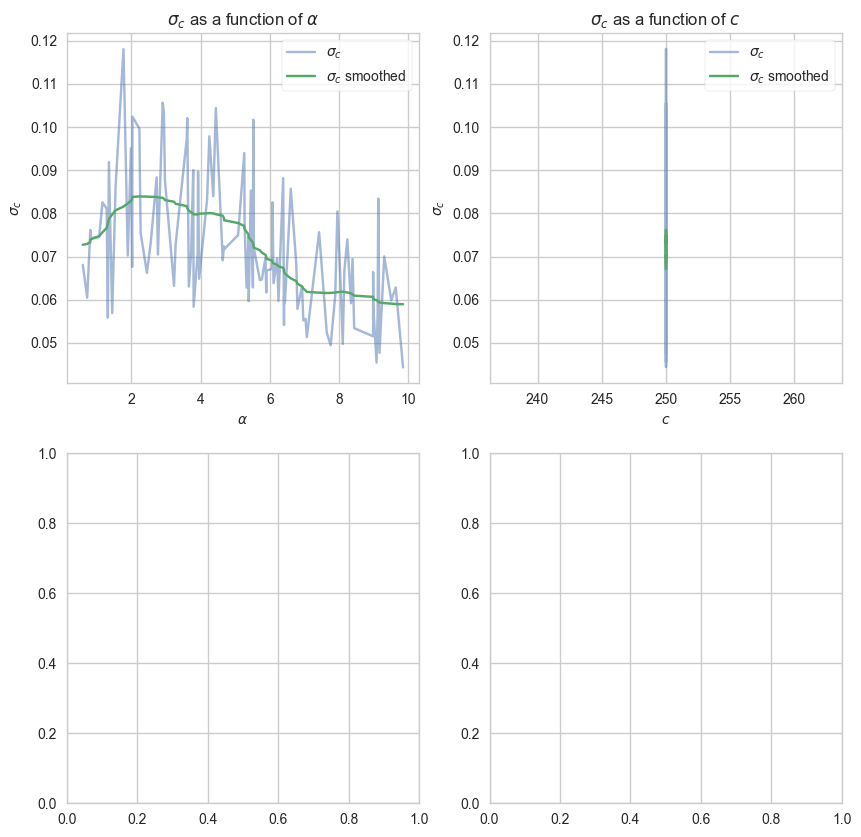

In [19]:
plot = plt_sigma_as_func_of_alpha_and_c(mu, sigma, y)


C:\Users\andre\AppData\Local\Temp\ipykernel_18752\4192795670.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mu_[:,i], y_, color=colors,cmap="viridis", s=20, marker="x", alpha = 0.4, label = "$\\mu$")
C:\Users\andre\AppData\Local\Temp\ipykernel_18752\4192795670.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(c_/500, y_, color=colors, cmap="viridis", s=10, marker="o", label = "True value")
C:\Users\andre\AppData\Local\Temp\ipykernel_18752\4192795670.py:47: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable, label=f"$\\alpha$")


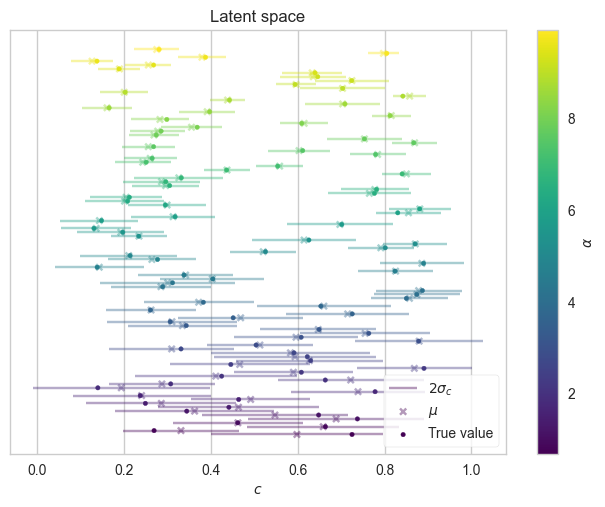

C:\Users\andre\AppData\Local\Temp\ipykernel_18752\4192795670.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(alpha_, y_, color=colors, cmap="viridis", s=10, marker="o", label = "True value")


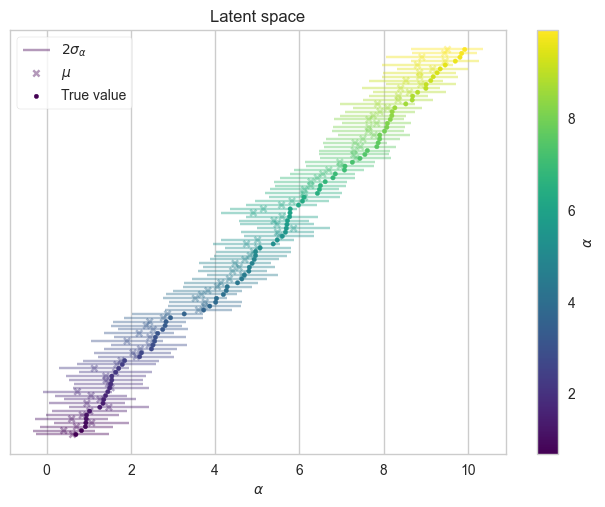

In [246]:

dict_ = {0: "c", 1: "\\alpha"}

for i in range(2):

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    # sort by sigma 
    # idx = np.argsort(y[:,3])
    idx = np.argsort(y[:,3].flatten())
    # idx random
    # idx = np.argsort(sigma[:,i].flatten())
    z_ = z[idx]
    y_ = y[idx]
    alpha_ = y_[:,3]
    c_ = y_[:,0]
    mu_ = mu[idx]
    # alpha_ = z_[:,1]    
    sigma_ = sigma[idx]

    # colors vidris color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(z_[:,i])))

    # randomize color order
    # np.random.shuffle(colors)
    # Make spacing between points on y-axis
    y_ = np.linspace(0, 1, z_.shape[0])
    # make horizontal lines 2*sigma above and below the mean
    plt.hlines(y_, mu_[:,i]-2*sigma_[:,i], mu_[:,i]+2*sigma_[:,i], color=colors, 
               cmap="viridis", alpha=0.4, label = f"$2\\sigma_{dict_[i]}$")
    # plot mu with marker x
    plt.scatter(mu_[:,i], y_, color=colors,cmap="viridis", s=20, marker="x", alpha = 0.4, label = "$\\mu$")

    if i == 1:
        plt.scatter(alpha_, y_, color=colors, cmap="viridis", s=10, marker="o", label = "True value")
    else:
        plt.scatter(c_/500, y_, color=colors, cmap="viridis", s=10, marker="o", label = "True value")


    # colorbar 
    # create a ScalarMappable and initialize a data structure
    mappable = plt.cm.ScalarMappable(cmap="viridis")
    # mappable.set_array(sigma_[:,i])
    # mappable.set_clim(min(sigma_[:,i]), max(sigma_[:,i]))
    mappable.set_array(alpha_)
    mappable.set_clim(min(alpha_), max(alpha_))
    plt.colorbar(mappable, label=f"$\\alpha$")

    plt.legend()
    # give legen a box frame
    plt.gca().legend(frameon=True)

    # make y-axis taller
    # remove ticks on y axis
    plt.yticks([])
    # SET LABEL FOR X AXIS
    text_cbar = f"${dict_[i]}$"

    plt.xlabel(text_cbar)

    plt.title("Latent space")
    plt.show()



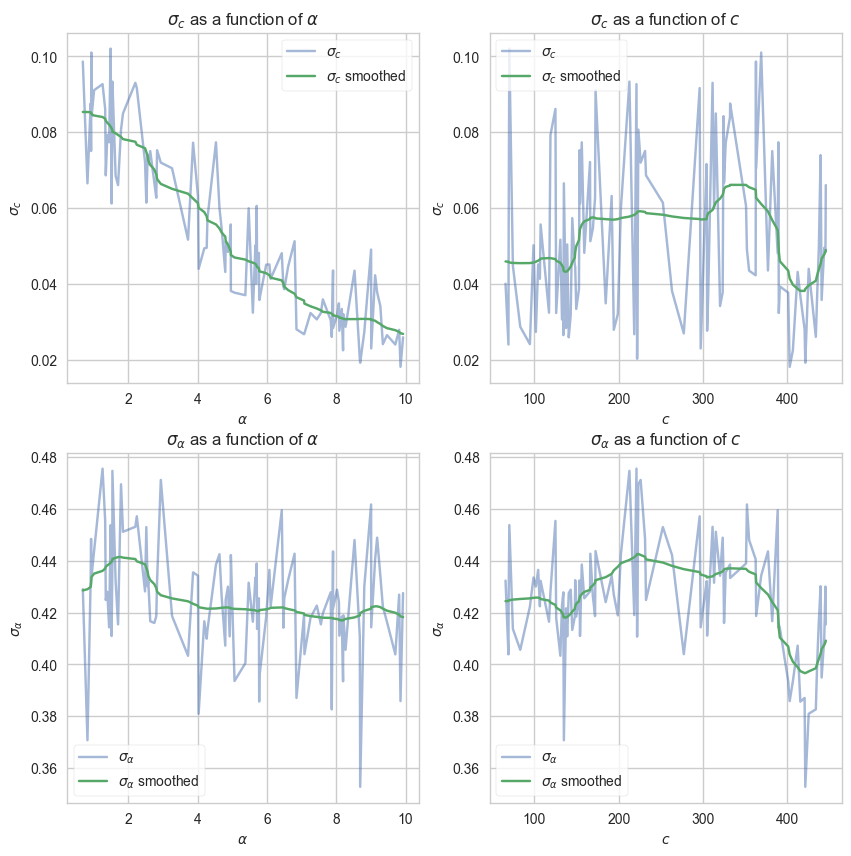

In [234]:


plt = plt_sigma_as_func_of_alpha_and_c(mu, sigma, y)